# Pharmaceutical Sales prediction across multiple stores


Business Need

You work at Rossmann Pharmaceuticals as a Machine Learning Engineer. The finance team wants to forecast sales in all their stores across several cities six weeks ahead of time. Managers in individual stores rely on their years of experience as well as their personal judgement to forecast sales.

The data team identified factors such as promotions, competition, school and state holidays, seasonality, and locality as necessary for predicting the sales across the various stores.

Your job is to build and serve an end-to-end product that delivers this prediction to analysts in the finance team.

In [1]:
!pip install category_encoders

In [2]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
from numpy import mean
from numpy import std
from numpy import absolute
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced visualisations
%matplotlib inline

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import os
import logging
import math
import re
import time
import random
import os
import pickle
import joblib

import category_encoders as ce
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

In [3]:
def log (path,file):
    '''Creating a log file to record the project's logs'''
    #check if file exists
    log_file= os.path.join(path,file)

    if not os.path.isfile(log_file):
        open(log_file,"w+").close()

    console_logging_format = "%(levelname)s %(message)s"
    file_logging_format = "%(levelname)s: %(asctime)s: %(message)s"

    #configure logger
    logging.basicConfig(level=logging.INFO,format=console_logging_format)
    logger=logging.getLogger()

    #file handler for output file
    handler=logging.FileHandler(log_file)

    #set logging level for file
    handler.setLevel(logging.INFO)

    #logging format
    formatter=logging.Formatter(file_logging_format)
    handler.setFormatter(formatter)
    
    #add handlers to logger
    logger.addHandler(handler)

    return logger

In [4]:
train= pd.read_csv("D:/work/week3/train.csv")
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
test= pd.read_csv("D:/work/week3/test.csv")
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
store = pd.read_csv("D:/work/week3/store.csv")
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# Data Cleaning and Wrangling

In [7]:

class information:
    def __init__(self):
        print('Data information object created')
    def get_shape(self,data):
        data_shape=data.shape
        print('Dataset shape:',data_shape)
    def get_null_values(self,data):
        missing=data.isnull().sum()
        print('\n Null values per column:\n',missing)

In [8]:
class preprocess():
    def __init__(self):
        print("Preprocessing the train data...")
    
    def get_features(self,train_df):
        train['Sales_per_Customer']=train['Sales']/train['Customers']
        
        train['Date']=pd.to_datetime(train['Date'])
        train.set_index('Date',inplace=True)
        train['Day']=train.index.day
        train['Month']=train.index.month
        train['Year']=train.index.year
        train['Weekday']=np.where(train['DayOfWeek']<6,1,0)
        return train

In [9]:
train= train[train["Open"] != 0]
train = train.loc[~(train['Sales'] == 0)]

In [10]:

class clean_store:
    def __init__(self):
        print('Cleaning Store Dataset')
    def fill_null(self,store):
        # fill NaN with a median value for competition distance, fill the other NaN valuescolumns , with 0
        store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(), inplace = True)
        store.fillna(0,inplace=True)
        print('Are there any null values? \n',store.isnull().any())

In [11]:
class clean_test():
    def __init__(self):
        print("Cleaning test dataframe")
    def is_null(self,test):
        null=test.isnull().sum()
        print("List of null values per column:\n",null)
        
        test.dropna(subset=['Open'],inplace=True)
        print('\n Any more null values?',test['Open'].isnull().any())


Store Dataset

In [12]:
inf=information()
inf.get_shape(store)
inf.get_null_values(store)

Data information object created
Dataset shape: (1115, 10)

 Null values per column:
 Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64



The stores with no promo information would probably mean they didn't participate in the promos, we replace with 0 For Competition distance, we replace with the median

In [13]:

clean=clean_store()
clean.fill_null(store)

Cleaning Store Dataset
Are there any null values? 
 Store                        False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
dtype: bool



Train dataset

In [14]:
inf=information()
inf.get_null_values(train)

Data information object created

 Null values per column:
 Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64


In [15]:
p1=preprocess()
p1.get_features(train)
#p1.sales_per_customer(train)
#p1.update_date(train)

Preprocessing the train data...


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales_per_Customer,Day,Month,Year,Weekday
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,9.482883,31,7,2015,1
2015-07-31,2,5,6064,625,1,1,0,1,9.702400,31,7,2015,1
2015-07-31,3,5,8314,821,1,1,0,1,10.126675,31,7,2015,1
2015-07-31,4,5,13995,1498,1,1,0,1,9.342457,31,7,2015,1
2015-07-31,5,5,4822,559,1,1,0,1,8.626118,31,7,2015,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-01,682,2,3375,566,1,0,a,1,5.962898,1,1,2013,1
2013-01-01,733,2,10765,2377,1,0,a,1,4.528818,1,1,2013,1
2013-01-01,769,2,5035,1248,1,0,a,1,4.034455,1,1,2013,1


Test dataset

In [16]:

inf=information()
inf.get_null_values(test)

Data information object created

 Null values per column:
 Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64


In [17]:
clean=clean_test()
clean.is_null(test)

Cleaning test dataframe
List of null values per column:
 Id                0
Store             0
DayOfWeek         0
Date              0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

 Any more null values? False


# Exploratory Data Analysis

In [18]:
sales = train[['Sales']]
holidays=sales.loc['2014-01-03':'2013-12-01'].sort_index()
holidays

,Sales
Date,
2013-12-02,10081
2013-12-02,6829
2013-12-02,10681
2013-12-02,13602
2013-12-02,15202
...,...
2014-01-03,5158
2014-01-03,7185
2014-01-03,5295


In [19]:
class seasonality():
    def __init__(self):
        print('Checking for seasonality in different store types...')
    def store_seasonality(self,train):
        pd.plotting.register_matplotlib_converters()

        # preparation: input should be float type
        sales = train[['Sales']]
        plt.figure(figsize=(12,6))
        sales.resample('W').sum().plot(color = 'Purple')
        plt.show()
        
    def christmas_seasonality(self,train):
        sales = train[['Sales']]
        holidays=sales.loc['2014-01-03':'2013-12-01'].sort_index()
        holidays.resample('D').sum().plot(color = 'Purple')
        plt.show()

In [20]:
#Factor plot
def plot_factor(data,x,y,col,hue):
    sns.factorplot(data=data,x=x,y=y,col=col,hue=hue)
    plt.show()
#Bar plot    
def plot_bar(data,x,y1,y2):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.barplot(data = data, x = x, y = y1,palette='PuBuGn') 
    plt.title(f'{x} VS {y1}')
    plt.subplot(1,2,2)
    sns.barplot(data = data, x = x, y = y2,palette='PuBuGn')
    plt.title(f'{x} VS {y2}')
    plt.show()
#Histogram
def plot_hist(data,col1,col2):
    sns.histplot(data=data,x=col1,y=col2,bins=30)
    plt.title(f'Distribution of {col1} by {col2}')
    plt.show()

Checking for seasonality in different store types...


<Figure size 864x432 with 0 Axes>

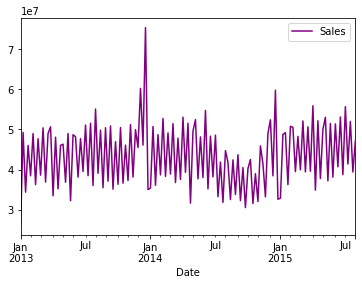

In [21]:
season=seasonality()
season.store_seasonality(train)


The plot shows that all store types experience a significant increase in sales around Dec25th To see how buyers behave before,during and after Christmas, we plot charts for December 2013 to understand buyer behaviour

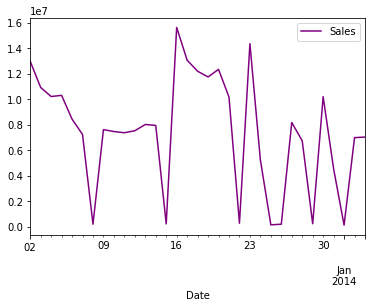

In [22]:
season.christmas_seasonality(train)

Because most stores close on Christmas, a few days before the holiday, particularly from 16th December onwards, sales significantly increase and start dropping from 23rd

# #Correlation between Sales and Customers


We merge Store and Train into one to have all the information in one dataset

In [23]:
train_store = pd.merge(train, store, how = 'inner', on = 'Store')
train_store.groupby(['StoreType'])['Store'].nunique()

StoreType
a    602
b     17
c    148
d    348
Name: Store, dtype: int64

<AxesSubplot:>

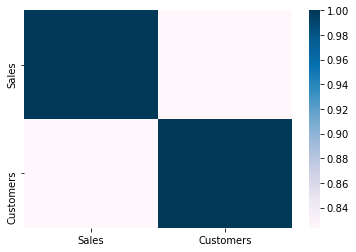

In [24]:
corr=train_store[['Sales','Customers']].corr()
sns.heatmap(corr, cmap="PuBu")


Customers and Sales have a correlation of 0.9, which indicates a strong positive relationship, meaning they both move in the same direction

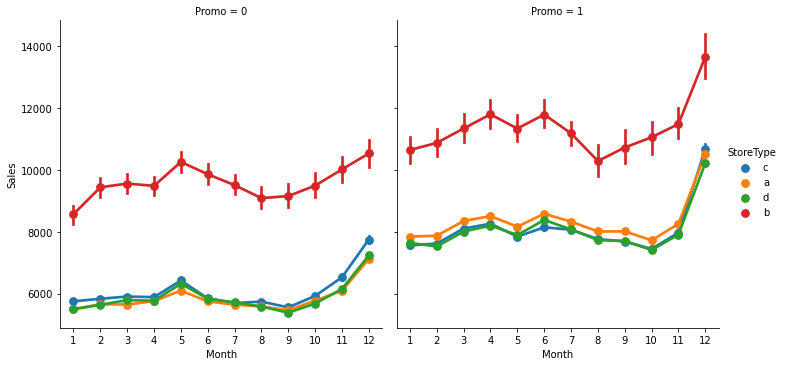

In [25]:
plot_factor(train_store,'Month',"Sales",'Promo','StoreType')

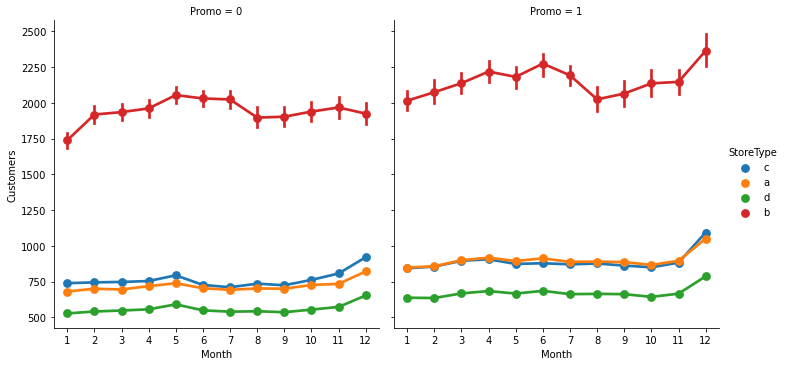

In [26]:
plot_factor(train_store,'Month',"Customers",'Promo','StoreType')

Store Type b has the highest sales and customers per month overall, with and without the promo

However, we can see that promotions lead to higher sales and customers for all store types

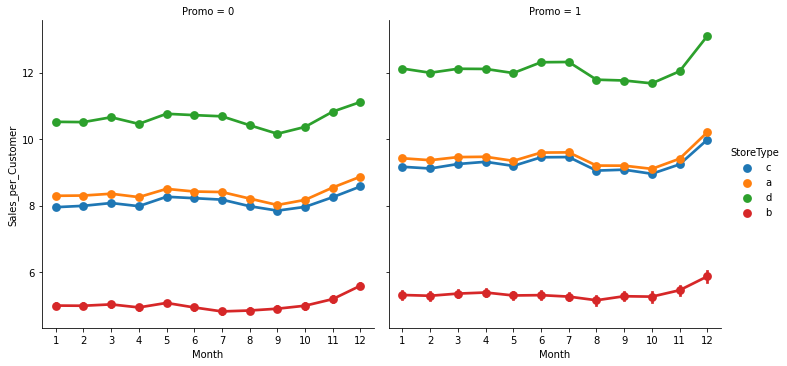

In [27]:

plot_factor(train_store,'Month','Sales_per_Customer','Promo','StoreType')

StoreType b has the lowest sales_per_customer, even though it has the highest sales and customers in general

This means that the store gets lots of customers who by many low-value goods

## Could the promos be deployed in more effective ways? Which stores should promos be deployed in?

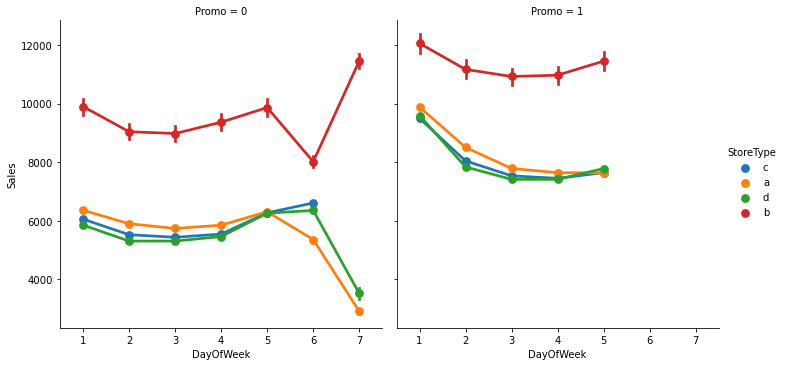

In [28]:
plot_factor(train_store,'DayOfWeek',"Sales",'Promo','StoreType')

In [ ]:
ttt

Store Type a has the most sales on Sundays,

Store Types b,c,d should try deploying promos on weekends to bump their sales

## Which stores are opened on all weekdays? How does that affect their sales on weekends?

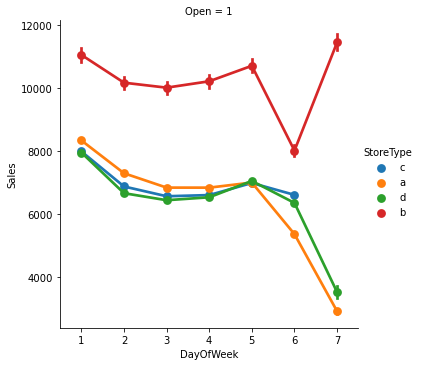

In [29]:

plot_factor(train_store,'DayOfWeek',"Sales",'Open','StoreType')


All the store types open daily, store type b seems to have the highest sales on Sundays, and lowest on Saturdays

In [30]:
train_store.groupby('StoreType')['Customers','Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943



Store Type a has the highest amount of customers and Sales, followed by Store Type d

## Check how the assortment type affects sales

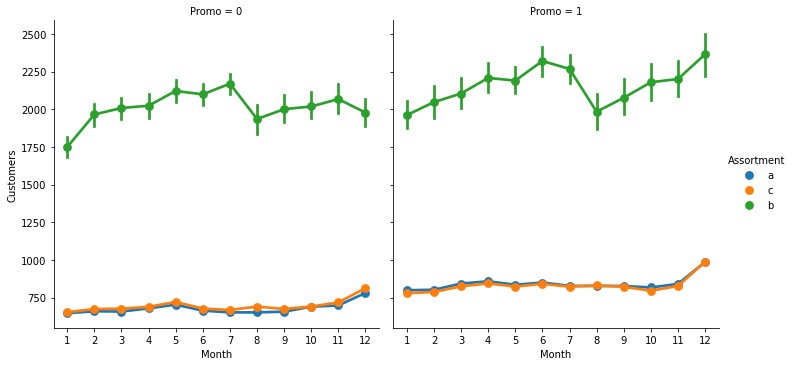

In [31]:
plot_factor(train_store,'Month',"Customers",'Promo','Assortment')

Assortment a has the highest sales and customers per month. Promotions lead to higher sales and customers for all assortment types

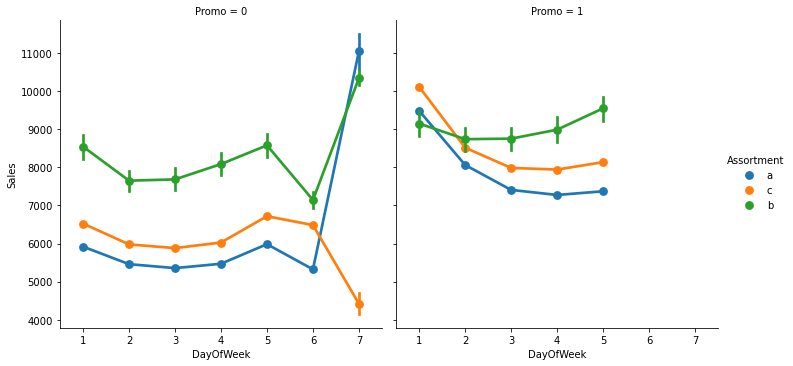

In [32]:
plot_factor(train_store,'DayOfWeek',"Sales",'Promo','Assortment')

Assortment A has their highest sales on Sundays, while b and c have no sales on Sundays

Promotions don't happen on weekends

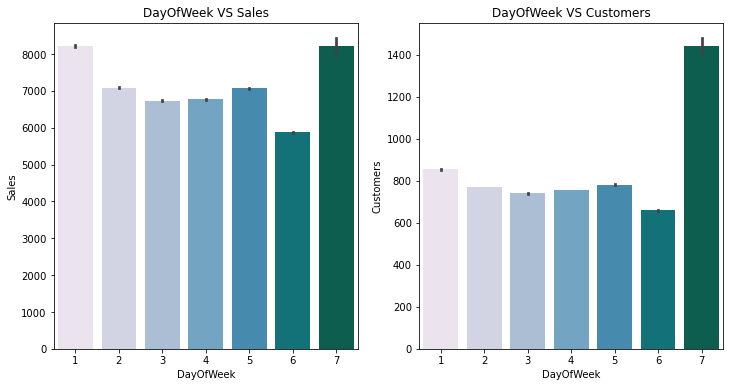

In [33]:

plot_bar(train_store,'DayOfWeek','Sales','Customers')

Mondays have the most sales and customers, may be because most stores close on Sundays

Fridays also seem to have a high number of sales and customers

## How does the distance to the next competitor affect sales?

In [34]:
pd.set_option('display.float_format',str)
train_store['Decile_rank'] = pd.qcut(train_store['CompetitionDistance'], 5, labels = False) 
train_store.groupby('Decile_rank').agg({'Decile_rank':'count','Sales':'sum'})

,Decile_rank,Sales
Decile_rank,,
0,169487,1287591800
1,169640,1161532905
2,167873,1124487817
3,168853,1148973176
4,168485,1150594925


<AxesSubplot:xlabel='CompetitionDistance', ylabel='Density'>

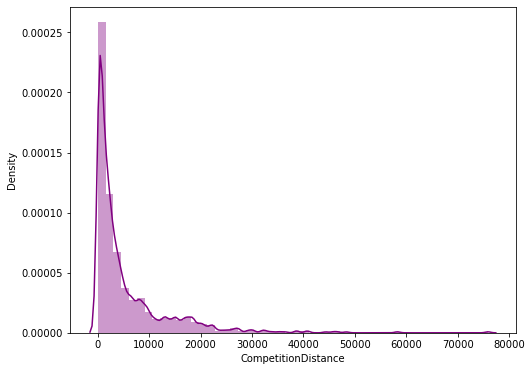

In [35]:
#CompetitionDistance
fig = plt.figure(figsize = (8,6))
sns.distplot(train_store.CompetitionDistance, color = 'purple')

The total number of sales across the decile classes is somewhat balanced, apart from the first class which has a bit higher values compared to the rest.

The stores could be located in densely populated areas hence, distance to nearest competitor has a small influence


Feature Engineering

In [36]:
train.head(2)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales_per_Customer,Day,Month,Year,Weekday
Date,,,,,,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1,9.482882882882883,31,7,2015,1
2015-07-31,2,5,6064,625,1,1,0,1,9.7024,31,7,2015,1


In [37]:

train_store=pd.merge(train,store,how='left',on='Store')
train_store.sample(5)

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales_per_Customer,Day,...,Weekday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
28982,1025,4,8714,946,1,1,0,0,9.211416490486258,2,...,1,a,a,720.0,11.0,2009.0,0,0.0,0.0,0
28990,1033,4,16852,1420,1,1,0,0,11.867605633802818,2,...,1,a,a,7680.0,3.0,2006.0,0,0.0,0.0,0
191520,801,3,4531,426,1,1,0,0,10.636150234741784,7,...,1,d,a,48330.0,4.0,2013.0,0,0.0,0.0,0
687491,767,5,7671,799,1,1,0,0,9.600750938673341,21,...,1,a,c,13080.0,0.0,0.0,0,0.0,0.0,0
360758,494,6,5855,933,1,0,0,0,6.27545551982851,7,...,0,b,a,1260.0,6.0,2011.0,0,0.0,0.0,0


In [38]:

train_store['PromoInterval'].unique()

array([0, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [39]:
train_store.dropna(inplace=True)

In [40]:
train_store['DayOfWeek']=train_store['DayOfWeek'].apply(str)
train_store['Year']=train_store['Year'].apply(str)
train_store['Promo']=train_store['Promo'].apply(str)
train_store['Promo2']=train_store['Promo2'].apply(str)
train_store['SchoolHoliday']=train_store['SchoolHoliday'].apply(str)
train_store['StateHoliday']=train_store['StateHoliday'].apply(str)
#train_store['WeekOfYear']=train_store['WeekOfYear'].apply(str)

In [41]:

train_store.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844338 entries, 0 to 844337
Data columns (total 22 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Store                      844338 non-null  int64  
 1   DayOfWeek                  844338 non-null  object 
 2   Sales                      844338 non-null  int64  
 3   Customers                  844338 non-null  int64  
 4   Open                       844338 non-null  int64  
 5   Promo                      844338 non-null  object 
 6   StateHoliday               844338 non-null  object 
 7   SchoolHoliday              844338 non-null  object 
 8   Sales_per_Customer         844338 non-null  float64
 9   Day                        844338 non-null  int64  
 10  Month                      844338 non-null  int64  
 11  Year                       844338 non-null  object 
 12  Weekday                    844338 non-null  int32  
 13  StoreType                  84

In [42]:

train_store.isnull().any()

Store                        False
DayOfWeek                    False
Sales                        False
Customers                    False
Open                         False
Promo                        False
StateHoliday                 False
SchoolHoliday                False
Sales_per_Customer           False
Day                          False
Month                        False
Year                         False
Weekday                      False
StoreType                    False
Assortment                   False
CompetitionDistance          False
CompetitionOpenSinceMonth    False
CompetitionOpenSinceYear     False
Promo2                       False
Promo2SinceWeek              False
Promo2SinceYear              False
PromoInterval                False
dtype: bool

In [43]:
#drop Date and Open columns
#drop rows where Sales=0
train_store = train_store.drop(['Open','Customers'],axis=1)
train_store = train_store.loc[~(train_store['Sales'] == 0)]

In [44]:
X=train_store.loc[:,train_store.columns != 'Sales']
X = X.drop(['PromoInterval'],axis=1)
y=train_store['Sales']

In [45]:
from sklearn.model_selection import train_test_split

In [46]:
train, test = train_test_split(train_store,test_size=0.2)
train,val=train_test_split(train,test_size=0.2)

In [47]:
cat_cols = ['StateHoliday','SchoolHoliday','DayOfWeek','Promo','Promo2','Assortment','StoreType','Year']
num_cols = [i for i in X.columns if i not in cat_cols]

num_transformer = Pipeline(steps = [('imp', IterativeImputer(initial_strategy='median')),
                                    ('scaler', StandardScaler())])

cat_transformer = Pipeline(steps = [('imp', SimpleImputer(strategy='most_frequent')),
                                    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[('cat',cat_transformer,cat_cols)])

In [48]:
preprocessor.fit(X)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('imp',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['StateHoliday', 'SchoolHoliday', 'DayOfWeek',
                                  'Promo', 'Promo2', 'Assortment', 'StoreType',
                                  'Year'])])

In [49]:
train_store.head(2)

,Store,DayOfWeek,Sales,Promo,StateHoliday,SchoolHoliday,Sales_per_Customer,Day,Month,Year,Weekday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,1,0,1,9.482882882882883,31,7,2015,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,5,6064,1,0,1,9.7024,31,7,2015,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [50]:
train_store.to_csv(r"C:\Users\DELL\sales\data\train_store.csv", index=False)